In [1]:
# 라이브러리 로드
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 모델 라이브러리 로드
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# 데이터 로드
data_dir = r'C:\Users\user\Desktop\AIFFEL\Day17\data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('라이브러리 및 데이터 불러오기 완료')

라이브러리 및 데이터 불러오기 완료


# 2. 데이터 전처리

In [2]:
# 날짜 다듬기, id 제거, 가격 분리
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
price_data = train['price']
train_id = train['id']
test_id = test['id']

del train['price']
del train['id']
del test['id']
train_len = len(train)
log_price_data = np.log1p(price_data)

print('         <데이터 기본 정보>')
train.info()

         <데이터 기본 정보>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int32  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null

In [3]:
# feature data 결측치 확인
data = pd.concat((train, test), axis = 0)
#msno.matrix(data)  # 중복 검사 불필요하다 판단되어 배제.
print('<feature data 결측치 확인>')
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))
    
# price data의 결측치 확인
price_null_check = pd.isnull(price_data)  # null_check가 True 이면 id를 담아라.
price_null_data = price_data[price_null_check]
price_null_data.head()
print('\n<price data 결측치 확인>')
print('{}: {}'.format('price', len(price_null_data.values)))

# feature, price data shape 확인
print('\n<feature, price data shape 확인>')
print(train.shape)
print(test.shape)
print(price_data.shape)

<feature data 결측치 확인>
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0

<price data 결측치 확인>
price: 0

<feature, price data shape 확인>
(15035, 19)
(6468, 19)
(15035,)


Price data


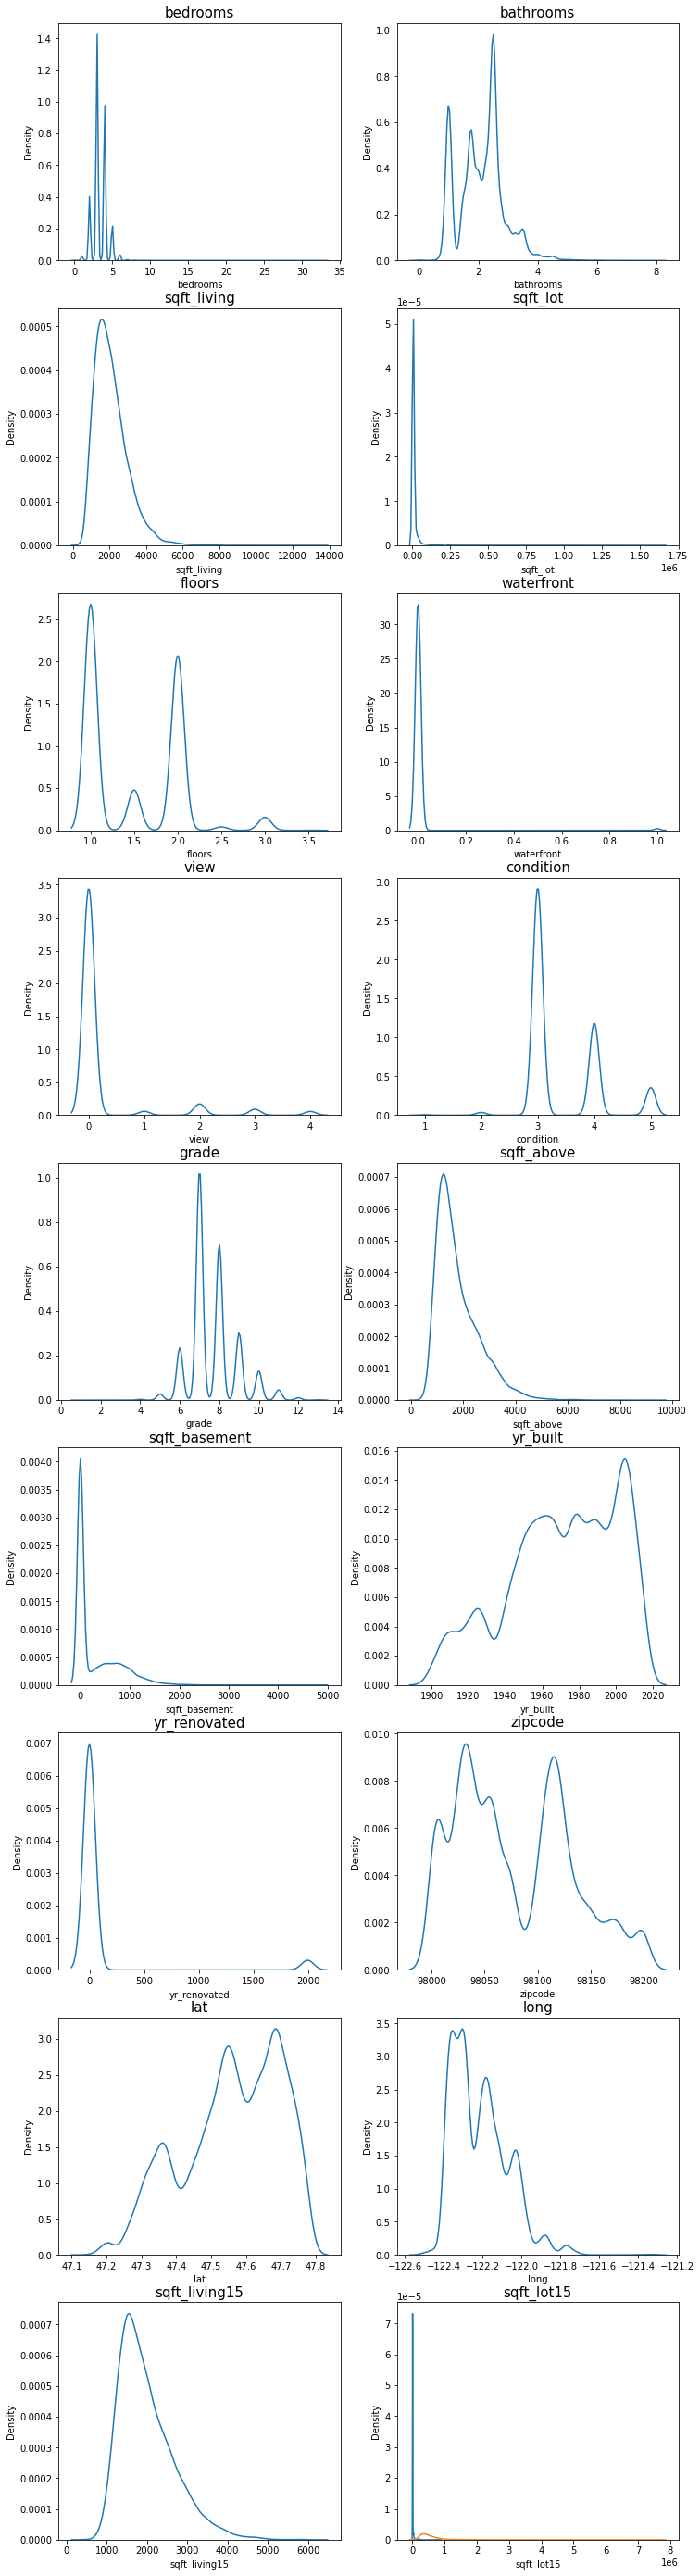

Log Price data


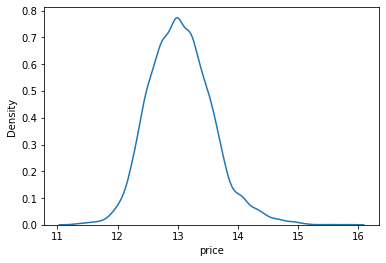

In [4]:
# Feature data 분포 시각화
fig, ax = plt.subplots(9, 2, figsize = (12, 50)) 

count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax = ax[row][col])
        ax[row][col].set_title(columns[count], fontsize = 15)
        count += 1
        if count == 19:
            break
            
# price_data, log_price_data 분포 시각화. 

print('Price data')
sns.kdeplot(price_data)
plt.show()
print('Log Price data')
sns.kdeplot(data= log_price_data)
plt.show()



### 중간 회고
- 위도/경도를 주소로 바꿀 수 있을 것 같아 찾아보니 구글 API를 이용하였다고 한다. 따라해보려 했으나 유료여서 포기..
- 데이터 정제는 이전 프로젝트에서 진행해 보았으므로, 시간이 남으면 하려고 최후 순위로 미루어 두었다. 하지만 결국 시간이 부족해 추가 정제는 시행하지 않았다.

# 3. 모델 훈련
- 3 가지 이상의 다양한 모델 시도: GBR, XGBR, LGBMR, RFR 
- 하이퍼 파라미터 튜닝해가며 시도.
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합 찾아보기
- 베이스라인 커널에서 활용했던 블렌딩 방법 활용하기

## (1) 개별 모델 훈련 및 하이퍼 파라미터 fine-tuning

In [5]:
# 하이퍼 파라미터

# Common
learning_rate = 0.1
random_state= 180      


#GB
GB_learning_rate = learning_rate  # 학습률. 통일함.

# XGB
XGB_learning_rate=learning_rate,  # 학습률.  통일함.
XGB_max_depth = -1,  # 나무 깊이. 분기 개수. 기본값은 -1, 제한없이 분기.
XGB_booster='dart'

# LGBM
LGBM_learning_rate = learning_rate   # 학습률. 통일함.
LGBM_min_child_samples = 20   # 최종 리프노드가 되기 위한 레코드 수. 과적합 제어용.
LGBM_num_leaves = 25        # 하나의 트리가 가지는 최대 리프 개수
LGBM_boosting_type = 'goss'    # gbdt: 일반 . rf: 랜덤 포레스트.

# RF
RF_max_features = 10   # 최적의 분할을 위해 고려할 최대 특징 개수.
RF_min_samples_split = 7   # 노드를 분할하기 위한 최소한의 샘플데이터 수. 작을수록 과적합가능성 증가.

In [6]:
# 모델 지정
gbr = GradientBoostingRegressor(random_state=random_state,
                                   learning_rate = learning_rate)
xgbr = XGBRegressor(random_state=random_state,
                       learning_rate = learning_rate, 
                       booster=XGB_booster)
lgbmr = LGBMRegressor(random_state=random_state,
                        learning_rate = learning_rate,
                        min_child_samples = LGBM_min_child_samples,
                        num_leaves = LGBM_num_leaves,
                        boosting_type = LGBM_boosting_type)
rfr = RandomForestRegressor(random_state = random_state,
                                 max_features = RF_max_features,
                                min_samples_split = RF_min_samples_split)

models = [gbr, xgbr, lgbmr, rfr]

print('모델 지정 및 삽입 완료')

모델 지정 및 삽입 완료


In [7]:
def rmse(train_price_test, train_price_pred):  
    return np.sqrt(mean_squared_error(np.expm1(train_price_test), np.expm1(train_price_pred)))
    

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state 고정.
        ### price_data 가 아니라 log_price_data를 넣어줘야 한다. 
        ### 숫자가 튀어버리면 ValueError: Input contains NaN, infinity or a value too large for dtype('float64'). 가 나타남.        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state= random_state, test_size = 0.2)
        
        # 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)
                
        # 결과의 RMSE 값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # DataFrame에 변환 저장. 오름차순으로 하여 가장 편차가 적은게 우선순위로.
        score_df = pd.DataFrame(df, index = ['RMSE']).T.sort_values('RMSE', ascending = True)               

    return score_df

get_scores(models, train, log_price_data)
                              

,RMSE
XGBRegressor,111180.132345
LGBMRegressor,112721.598297
RandomForestRegressor,131356.985898
GradientBoostingRegressor,133572.820832


### 중간 회고
- 아래 그림과 같은 방식으로, 하이퍼 파라미터에 대해 근처 값들을 넣어가며 가장 적합한 방식을 시험하였다.

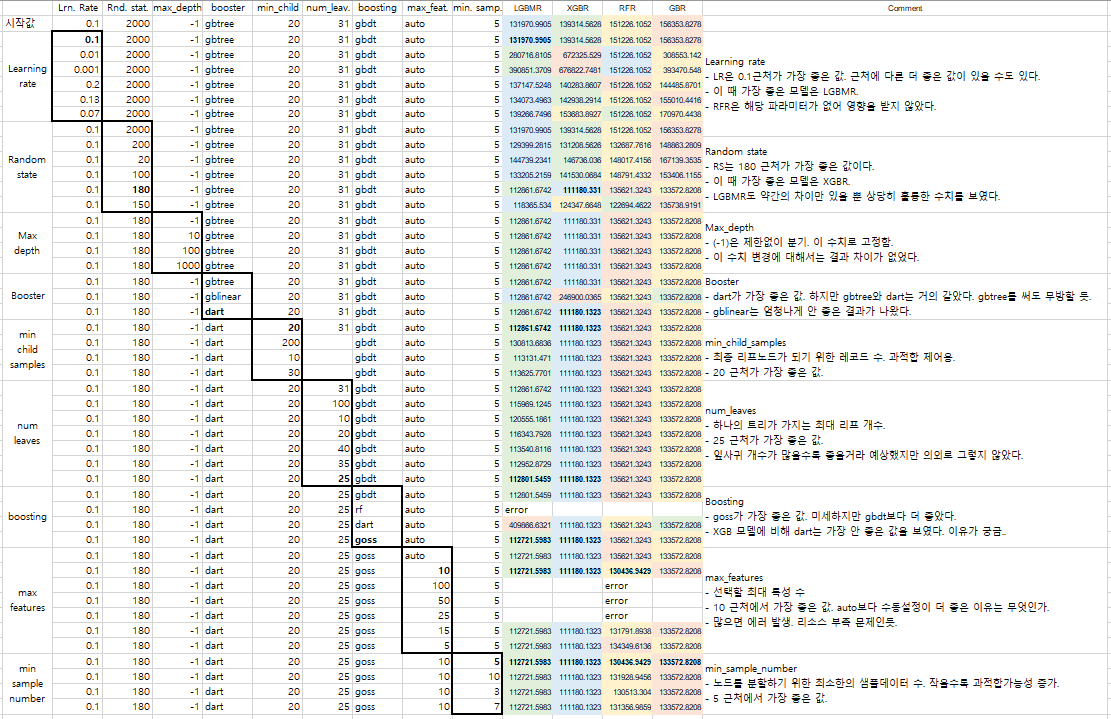

# (2) 그리드 탐색

In [8]:
# 그리드 탐색 파라미터 설정
param_grid = {'n_estimators': [10, 250],'max_depth': [5, 10],}

In [9]:
# 그리드 서치 함수
def my_GridSearch(model, train, log_price_data, param_grid, verbose = 2, n_jobs = 5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid = param_grid, scoring = 'neg_mean_squared_error',\
                             cv = 5, verbose = verbose, n_jobs = n_jobs)
    
    # model fitting
    grid_model.fit(train, log_price_data)
    
    #결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

# 4개 모델에 대해 그리드 서치 수행
GS_result=[]
for model in models:
    GS_result.append(my_GridSearch(model, train, log_price_data, param_grid, verbose = 2, n_jobs=5))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [10]:
print('GBR result')
print(GS_result[0])

GBR result
   max_depth  n_estimators     score     RMSLE
1          5           250 -0.026838  0.163823
3         10           250 -0.029394  0.171446
2         10            10 -0.065921  0.256751
0          5            10 -0.080686  0.284052


In [11]:
print('XGBR result')
print(GS_result[1])

XGBR result
   max_depth  n_estimators      score     RMSLE
1          5           250  -0.026685  0.163356
3         10           250  -0.026871  0.163925
0          5            10 -19.263072  4.388972
2         10            10 -19.263072  4.388972


In [12]:
print('LGBMR result')
print(GS_result[2])

LGBMR result
   max_depth  n_estimators     score     RMSLE
1          5           250 -0.026816  0.163757
3         10           250 -0.026848  0.163854
2         10            10 -0.080379  0.283511
0          5            10 -0.081716  0.285860


In [13]:
print('RFR result')
print(GS_result[3])

RFR result
   max_depth  n_estimators     score     RMSLE
3         10           250 -0.034250  0.185068
2         10            10 -0.037003  0.192360
1          5           250 -0.053854  0.232065
0          5            10 -0.056213  0.237092


### 중간 회고
- 하나만 돌렸을 때는 13만점대의 매우 저조한 점수를 얻었다.
- LGBMR: 137569.57764

## (3) Average blending
- RMSLE 값이 가장 작은 파라미터들을 이용하여 모델들을 돌린다.

In [15]:
# 최고 순위의 하이퍼 파라미터
common_max_depth = 5
common_n_estimators = 250

gbr_max_depth = common_max_depth
gbr_n_estimators = common_n_estimators
xgbr_max_depth = common_max_depth
xgbr_n_estimators = common_n_estimators
lgbmr_max_depth = common_max_depth
lgbmr_n_estimators = common_n_estimators
rfr_max_depth = 10
rfr_n_estimators = common_n_estimators


# 해당 하이퍼 파라미터를 모델에 적용.
gbr = GradientBoostingRegressor(random_state=random_state,
                                   learning_rate = learning_rate,
                               max_depth = gbr_max_depth,
                               n_estimators = gbr_n_estimators)
xgbr = XGBRegressor(random_state=random_state,
                       learning_rate = learning_rate,
                       booster=XGB_booster,
                   max_depth = xgbr_max_depth,
                               n_estimators = xgbr_n_estimators)
lgbmr = LGBMRegressor(random_state=random_state,
                        learning_rate = learning_rate,
                        min_child_samples = LGBM_min_child_samples,
                        num_leaves = LGBM_num_leaves,
                        boosting_type = LGBM_boosting_type,
                     max_depth = lgbmr_max_depth,
                               n_estimators = lgbmr_n_estimators)
rfr = RandomForestRegressor(random_state = random_state,
                                 max_features = RF_max_features,
                                min_samples_split = RF_min_samples_split,
                           max_depth = rfr_max_depth,
                               n_estimators = rfr_n_estimators)

# 블렌딩 모델
models = [{'model': gbr, 'name': 'Gradientboosting'}, 
          {'model': xgbr, 'name': 'XGBoost'},
          {'model': lgbmr, 'name': 'LightGBM'}]
          #{'model': rfr, 'name': 'RandomForest'}]   #RMSLE 값 높아 제외.

def get_cv_score(models):
    kfold = KFold(n_splits = 5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'],
                                           X=train.values, y=price_data, cv = kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

Model: Gradientboosting, CV score:0.8921
Model: XGBoost, CV score:0.8939
Model: LightGBM, CV score:0.8892


In [16]:
def AveragingBlending(models, x, y, sub_x):
    for m in models:
        m['model'].fit(x.values, y)
    
    # indentation 주의
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models])
    return np.mean(predictions, axis = 1)

y_pred = AveragingBlending(models, train, price_data, test)


### 중간 회고
- 그리드 서치에서 n_estimator 수치를 높이면 점수는 잘 나오게 되지만 시간이 너무 오래 걸린다.. 마지막 제출본은 점수 나온 것만 요약함. 나머지는 11만점을 약간 웃돌았다.
- RFR 모델은 그리드 서치에서 다른 3가지에 비해 RMLSE 값이 높았다. 
- 블렌딩에서 RFR은 제거하였다.


# 4. 결과 저장
- 최저 RMSLE 값: 1.64E-01
- 이 값을 출력한 모델:LGBMR
- 이 모델의 주요 파라미터: max_depth = 10, n_estimators = 100, 

In [17]:
def AB_save_submission(prediction):
    data_dir = r'C:\Users\user\Google 드라이브\AIFFEL\Day17\kaggle_kakr_housing\data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = f'{data_dir}/submission_AvrBl_md{common_max_depth }_ne{common_n_estimators}.csv'
    submission.to_csv(submission_csv_path, index = False)
    print('{} saved!'.format(submission_csv_path))
    
AB_save_submission(y_pred)

C:\Users\user\Google 드라이브\AIFFEL\Day17\kaggle_kakr_housing\data/submission_AvrBl_md5_ne250.csv saved!


# 최종 결과
- Kaggle 최종 점수는 아래 그림과 같이 109440.09051점이다.

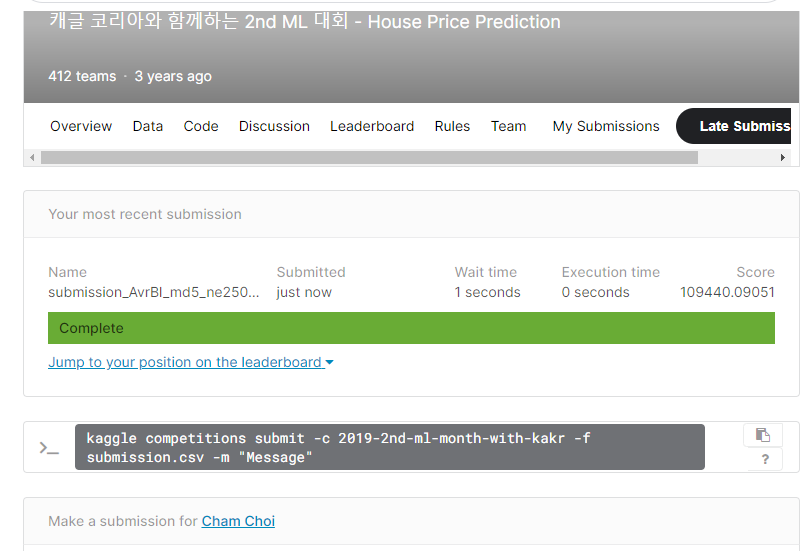

# 회고

- 전체 흐름: 로드 -> 전처리 -> 싱글 모델 -> 그리드 탐색 -> 블렌딩 -> 저장
- 하고 싶은 건 정말 많았는데 시간이 너무 부족했다..